# MlOps - Do jupyter ao .py

In [2]:
import joblib
import pandas as pd

from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score

In [3]:
print(fetch_california_housing()['DESCR'])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [4]:
X_house, y_house = fetch_california_housing(return_X_y=True, as_frame=True)

In [5]:
X_house['AvgBedsPerRoom'] = X_house['AveBedrms']/X_house['AveRooms']

In [24]:
X_house.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,AvgBedsPerRoom
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,0.146591
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,0.155797
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,0.129516
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,0.184458
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,0.172096


## Separando em treino e teste

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_house, y_house, test_size=0.3, random_state=42)

## Criando Pipelines

### Data Leakege

![Train Test](data-preprocessing-machine-learning-5.png)

#### Por que usar pipelines?

##### Qual o problema nesse trecho?

```python
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_house, y_house = fetch_california_housing(return_X_y=True, as_frame=True)
X_house_scaler = scaler.fit_transform(X_house)
X_train, X_test, y_train, y_test = train_test_split(
    X_house_scaler, y_house, test_size=0.3, random_state=42)
```

##### Podemos resolver parcialmente da seguinte forma:

```python
scaler = MinMaxScaler()
X_house, y_house = fetch_california_housing(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(
    X_house, y_house, test_size=0.3, random_state=42)

X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.fit_transform(X_test)

joblib.dump(X_train_scaler, "../model/scaler.gzip", compress="gzip")

```

Quais os pontos negativos dessa solução?

### Usando Pipelines

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


features_to_transform = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population',
                         'AveOccup', 'Latitude', 'Longitude', 'AvgBedsPerRoom']

# Definindo os passos que ocorreram pra a transformação
transformer = Pipeline(
    steps=[("standard_scaler", StandardScaler())]
)

# Definindo em quais colunas a transformação será aplicada
preprocessor = ColumnTransformer(
    transformers=[
        ("std", transformer, features_to_transform),
    ]
)

# Criando Pipeline
linear_regressor = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", LinearRegression())]
)

random_forest = Pipeline(
    steps=[("preprocessor", preprocessor),("model", RandomForestRegressor())]
)

In [9]:
import numpy as np

In [10]:
def select_best_model(
    models: list, X: pd.DataFrame, y: pd.DataFrame, cv: int = 3, scoring: str = "r2"
) -> Pipeline:
    """Seleciona o modelo que obtiver o melhor score

    Args:
        models (list): lista contendo os modelos
        X (pd.DataFrame): Matriz de features para treino
        y (pd.DataFrame): Variável resposta
        cv (int, optional): Número de validações cruzadas. Defaults to 3.
        scoring (str, optional): Forma de scorar o modelo. Defaults to "r2".

    Returns:
        sklearn.pipeline.Pipeline: Pipeline do modelo
    """
    scores = []
    for model in models:
        scores.append(
            cross_val_score(model, X, y, cv=cv, scoring=scoring).mean()
        )

    best_model_position = np.array(scores).argmax()
    return models[best_model_position]


In [11]:
%%time
model = select_best_model([linear_regressor, random_forest], X_train, y_train)

CPU times: user 12.7 s, sys: 1.74 s, total: 14.4 s
Wall time: 12.5 s


In [12]:
from sklearn import set_config
set_config(display="diagram")

In [13]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('std',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['MedInc', 'HouseAge',
                                                   'AveRooms', 'AveBedrms',
                                                   'Population', 'AveOccup',
                                                   'Latitude', 'Longitude',
                                                   'AvgBedsPerRoom'])])),
                ('model', RandomForestRegressor())])

#### Documentação
[Pipelines](https://scikit-learn.org/stable/modules/compose.html)

[ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html)

## Fit e score

In [14]:
from matplotlib import pyplot as plt

In [15]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("model score: %.3f" % model.score(X_test, y_test))

model score: 0.804


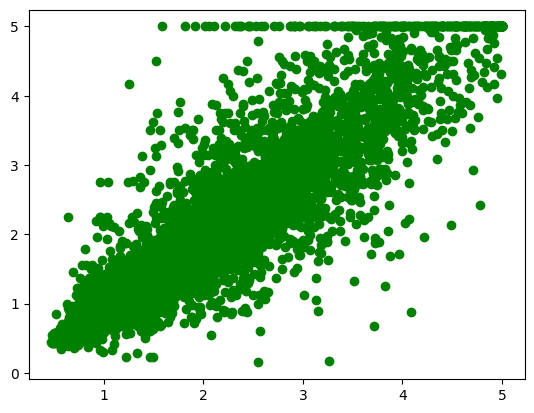

In [16]:
plt.scatter(y_pred, y_test, color='g')
plt.show()

## Salvando o modelo

In [17]:
%pwd

'/Users/gabriel.soares/Desktop/Projects/Personal/Tera/Tera-MlOpsProject/notebooks'

In [18]:
model_path = "regressor.gzip"

In [19]:
# Salvando o Modelo
joblib.dump(model, model_path, compress="gzip")

['regressor.gzip']

In [20]:
joblib.load(model_path).predict(X_test.iloc[0:1,:])[0]*100000

48916.0

In [23]:
joblib.load(model_path).predict(X_test.iloc[0:1,:])[0]*100000

48916.0